<a href="https://colab.research.google.com/github/Eudgene8/monitoring_of_moscow_land_plots/blob/main/monitoring_of_moscow_land_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мониторинг земельных участков на территории Москвы

**Цель исследования:** Провести аналитическое исследование и визуализацию данных по мониторингу земельных участков на территории Москвы для государственной компании.

**Ход исследования:** Данные берем из файла: data_for_test.xlsx Так как про данные ничего не известно потребуется провести обзор и предобработку данных. Проверить данные на ошибки и пустые значения.

**Этапы исследования:**

- Загрузка данных и изучение общей информации;
- Предобработка данных;
- Анализ данных;
- Выводы.

**Описание данных:**

Нам дана модель данных на трех листах: *задачи*, *мероприятия*, *объекты*.

*Задача* может быть связана с несколькими мероприятиями (значение поля «№ распоряжения/поручения» задачи содержится в значении поля «№ проверки» мероприятия).

*Мероприятие* может быть связано с одним объектом (по полю ID объекта самостроя).



[Ссылка на Tableau](https://public.tableau.com/views/Monitoring_of_Moscow_land_plots/sheet13?:language=en-US&publish=yes&:sid=&:display_count=n&:origin=viz_share_link)


## 1) Загрузка данных и изучение общей информации



### Открыть файл с данными.

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import folium
from folium import Map, Choropleth, Marker
from folium.plugins import MarkerCluster

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Загружаем файл
pth1 = '/content/drive/MyDrive/data_for_test_.xlsx'

if os.path.exists(pth1):
    moscow_land_plots = pd.ExcelFile(pth1)
    tasks = pd.read_excel(moscow_land_plots, 'Задачи')
    events = pd.read_excel(moscow_land_plots, 'Мероприятия')
    objects = pd.read_excel(moscow_land_plots, 'Объекты')
else:
    print('Что-то не так с файлом. Проверь файл с данными.')

## 2) Предобработка данных

### Посмотреть общую информацию по таблице и пропуски

In [14]:
# Выводим общую информацию
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758 entries, 0 to 2757
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   № п/п                     2758 non-null   int64 
 1   Id задачи                 2758 non-null   int64 
 2   Источник задачи           2758 non-null   object
 3   Округ                     2672 non-null   object
 4   Район                     2661 non-null   object
 5   Тематика                  2758 non-null   object
 6   Тип объекта               2758 non-null   object
 7   № распоряжения/поручения  2758 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 172.5+ KB


Видим что у нас имеются пропуски в двух столбцах "Округ" и "Район"

In [15]:
# Проверим количество пропусков
na = tasks.isna().sum().sort_values()
na_perc = round(tasks.isna().mean()*100,2).sort_values()
display(pd.DataFrame({'Количество пропусков':na,'% пропусков':na_perc}).style.format('{:.2f}').background_gradient('coolwarm'))

,Количество пропусков,% пропусков
№ п/п,0.00,0.00
Id задачи,0.00,0.00
Источник задачи,0.00,0.00
Тематика,0.00,0.00
Тип объекта,0.00,0.00
№ распоряжения/поручения,0.00,0.00
Округ,86.00,3.12
Район,97.00,3.52


После визуализации понятно, что пропусков не очень много всего по 3% на каждый столбец.Мешать исследованию они не будут поэтому убирать их не будем.

In [16]:
# Выводим общую информацию для двух оставшихся таблиц
for n in [events, objects]:
  n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3219 entries, 0 to 3218
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   № п/п                            3219 non-null   int64         
 1   Идентификатор мероприятия        3219 non-null   int64         
 2   № проверки                       3219 non-null   object        
 3   Дата создания карточки           3219 non-null   datetime64[ns]
 4   Вид мероприятия                  3219 non-null   object        
 5   Дата обновления карточки         3219 non-null   datetime64[ns]
 6   Дата проверки/обсл               3219 non-null   datetime64[ns]
 7   Дата акта                        3219 non-null   datetime64[ns]
 8   Продолжительность (час)          3219 non-null   float64       
 9   Время начала осмотра             3219 non-null   object        
 10  Время завершения осмотра         3219 non-null   object     

Так же видим что у нас имеются пропуски в обоих таблицах, посмотрим детальнее на процент пропусков.

In [17]:
# Проверим количество пропусков для двух оставшихся таблиц
for n in [events, objects]:
  na = n.isna().sum().sort_values()
  na_perc = round(n.isna().mean()*100,2).sort_values()
  display(pd.DataFrame({'Количество пропусков':na,'% пропусков':na_perc}).style.format('{:.2f}').background_gradient('coolwarm'))

,Количество пропусков,% пропусков
№ п/п,0.00,0.00
Наличие признаков угроз,0.00,0.00
Незавершенное строительство,0.00,0.00
Строительство возобновлено,0.00,0.00
Пресечено строительство,0.00,0.00
Ведется строительство,0.00,0.00
Площадь объекта,0.00,0.00
Тип объекта,0.00,0.00
Район,0.00,0.00
Округ,0.00,0.00


,Количество пропусков,% пропусков
№ п/п,0.00,0.00
Отложенный демонтаж,0.00,0.00
Фактическое использование,0.00,0.00
ЗПО,0.00,0.00
Разр. на стр.,0.00,0.00
ЕГРП,0.00,0.00
ID первого КИМ,0.00,0.00
№ первого КИМ,0.00,0.00
Дата первого КИМ,0.00,0.00
Дата акта первого КИМ,0.00,0.00


После визуализации данных по таблицам Мероприятия и Объекты видим что есть столбцы с пропусками в 100%.

При этом кажется логичным что столбцы "Отказ от ознакомления с актом", "Признаки угроз", "ID НТО" обсолютно пустые. Аналогично не все строки заполнены в "Право пользования" и "Статьи нарушений" что выглядил логичным так как нарушений могло не быть.

Что касается столбцов "Измененная дата демонтажа" и "Плановая дата демонтажа" так же считаю что пропуски могут быть так как таких дат не было, либо еще не было но будут внесены позднее. Аналогично и для столбцов "Лицо, осуществившее демонтаж", "Дата демонтажа", "Дата выявления", "Вид мероприятия".

Поэтому удалять или заменять пропуски в данной ситуаци не будем. Продолжим работу с теми данными что у нас есть.

### Проверить дуликаты

In [18]:
# Теперь проверим таблицы на явные дубликаты
# Создадим словарь
dataframes = {
    'tasks': tasks,
    'events': events,
    'objects': objects
}

# Выведем результаты
for name, df in dataframes.items():
    print(f"Количество явных дубликатов в {name}:", df.duplicated().sum())

Количество явных дубликатов в tasks: 0
Количество явных дубликатов в events: 0
Количество явных дубликатов в objects: 0


Видим что явных дубликатов в таблицах нет.

In [19]:
# Проверим не явные дубликаты по Id задачи, источнику задачи, округу, и району
tasks[tasks.duplicated(subset = ['Id задачи', 'Источник задачи', 'Округ', 'Район'], keep = False)]

,№ п/п,Id задачи,Источник задачи,Округ,Район,Тематика,Тип объекта,№ распоряжения/поручения


In [20]:
# Аналогично для талицы events по № проверки, идентификатору мероприятия, виду мероприятия
events[events.duplicated(subset = ['№ проверки', 'Идентификатор мероприятия', 'Вид мероприятия'], keep = False)]

,№ п/п,Идентификатор мероприятия,№ проверки,Дата создания карточки,Вид мероприятия,Дата обновления карточки,Дата проверки/обсл,Дата акта,Продолжительность (час),Время начала осмотра,...,Площадь пресечения,Ведется строительство,Пресечено строительство,Строительство возобновлено,Незавершенное строительство,Наличие признаков угроз,Признаки угроз,ID НТО,ID объекта самостроя,Нарушение ОАТИ


In [21]:
# Аналогично для талицы objects по идентификатору объекта, названию объекта, округу и району
objects[objects.duplicated(subset = ['Идентификатор объекта', 'Название объекта', 'Округ', 'Район'], keep = False)]

,№ п/п,Идентификатор объекта,Название объекта,Дата создания карточки объекта,Основание выявления/первого обследования,Вид мероприятия,Округ,Район,Тип объекта,Площадь/длина самостроя,...,Дата первого КИМ,Дата акта первого КИМ,Результат первого КИМ,Состояние верификации первого КИМ,ID последнего КИМ,№ последнего КИМ,Дата последнего КИМ,Дата акта последнего КИМ,Результат последнего КИМ,Состояние верификации последнего КИМ


Не явных дубликтов так же не обнаружено.

**Вывод:**

В результате проверки пустых строк в трех таблицах получили вот такую информацию.

После визуализации понятно, что пропусков в таблице tasks не очень много всего по 3% на каждый столбец, а это "Округ" и "Район". Мешать исследованию они не будут поэтому убирать их не будем.

В таблицах events и objects так же имеются столбцы с пропусками.
При этом кажется логичным что столбцы "Отказ от ознакомления с актом", "Признаки угроз", "ID НТО" обсолютно пустые. Аналогично не все строки заполнены в "Право пользования" и "Статьи нарушений" что выглядил логичным так как нарушений могло не быть.

Что касается столбцов "Измененная дата демонтажа" и "Плановая дата демонтажа" так же считаю что пропуски могут быть так как таких дат не было, либо еще не было но будут внесены позднее. Аналогично и для столбцов "Лицо, осуществившее демонтаж", "Дата демонтажа", "Дата выявления", "Вид мероприятия".

Аналогично первой таблице пропуски не трогаем, продолжаем работу с таблицами.

Яных и не явных дубликатов в таблицах нет.

## 3) Анализ данных

### Общее количество объектов по округам

In [22]:
 # На основании таблицы events посчитаем общее количество объектов по округам.
district_count = events.groupby('Округ', as_index=False)['Тип объекта'].agg('count').sort_values(by = 'Тип объекта', ascending = False)
district_count.columns = ['Округ', 'Количество']
district_count

,Округ,Количество
9,ЦАО,640
11,ЮВАО,561
0,ВАО,419
6,СВАО,326
10,ЮАО,275
5,САО,215
1,ЗАО,209
7,СЗАО,185
2,ЗЕЛАО,140
4,НАО,102


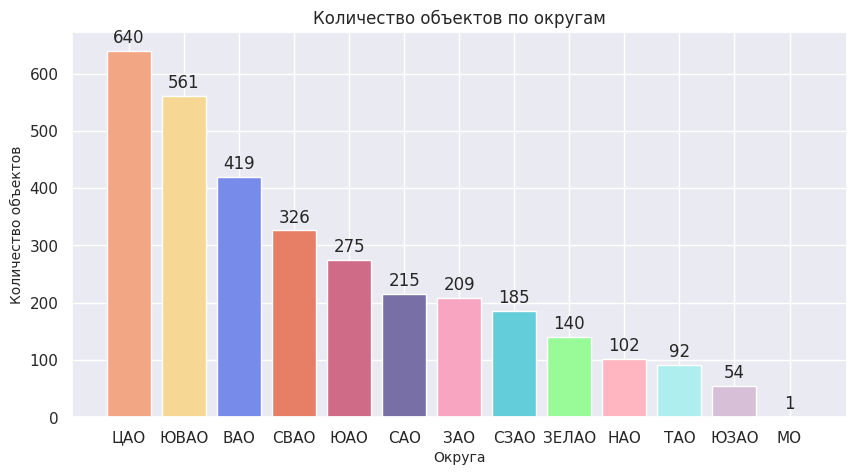

In [64]:
# Посмотрим на распреление с помошью столбчатой диаграммы

# Извлекаем данные для списка
labels = district_count['Округ']
sizes = district_count['Количество']

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(labels, sizes, color=['#f3a683', '#f7d794', '#778beb',
                                    '#e77f67', '#cf6a87', '#786fa6',
                                    '#f8a5c2', '#63cdda', '#98FB98',
                                    '#FFB6C1', '#AFEEEE', '#D8BFD8'])

# Добавляем подписи количества объектов
ax.bar_label(bars, padding=3)

# Устанавливаем заголовок и подписи осей
ax.set_title('Количество объектов по округам')
ax.set_xlabel('Округа', fontsize=10)
ax.set_ylabel('Количество объектов', fontsize=10)

# Рисуем диаграмму
plt.show()

Видим что коколо 50% процентов всех объектов находится в трех округах: ЦАО, ЮВАО и ВАО. При этом меньше всего в ТАО, ЮЗАО, МАО.

Так же для наглядности выведем данные по количеству объектов в каждом округе на карте Москвы. Для этого воспользуемся геоданными из открытых источников. Файл с данными что использовался в проекте практикума не подходит, так как в нем только 9 округов, а у нас их 13.

In [24]:
# Путь к файлу геоджисон
path_to_geojson = '/content/drive/MyDrive/moskow.geojson'

In [25]:
# Первым делом проверим какие данные содержит файл json
with open(path_to_geojson, 'r') as file:
    # Загружаем данные из файла в переменную
    data = json.load(file)

# Извлекаем список значений из feature.properties.ABBREV
abbrev_values = [feature['properties']['ABBREV'] for feature in data['features']]

# Выводим список значений
print(abbrev_values)

['ТАО', 'НАО', 'ЗЕЛАО', 'ЮЗАО', 'ЮВАО', 'ЦАО', 'САО', 'СЗАО', 'СВАО', 'ЮАО', 'ВАО', 'ЗАО']


Видим что три округа названы по другому. То есть нам нужно переименовать 'Троицкий', 'Новомосковский', 'ЗелАО' в соответствии с данными в нашей таблице.

In [26]:
# Для переименования воспользуемся функцией
with open(path_to_geojson, 'r') as file:
    # Загружаем данные из файла в переменную
    data = json.load(file)

# Функция для замены значений
def replace_values(value):
    if value == 'Троицкий':
        return 'ТАО'
    elif value == 'Новомосковский':
        return 'НАО'
    elif value == 'ЗелАО':
        return 'ЗЕЛАО'
    else:
        return value

# Изменяем значения в данных
for feature in data['features']:
    feature['properties']['ABBREV'] = replace_values(feature['properties']['ABBREV'])

# Сохраняем изменения обратно в файл
with open(path_to_geojson, 'w') as file:
    json.dump(data, file, indent=4)

In [27]:
# Проверяем что получилось
with open(path_to_geojson, 'r') as file:
    # Загружаем данные из файла в переменную
    data = json.load(file)

# Извлекаем список значений из feature.properties.ABBREV
abbrev_values = [feature['properties']['ABBREV'] for feature in data['features']]

# Выводим список значений
print(abbrev_values)

['ТАО', 'НАО', 'ЗЕЛАО', 'ЮЗАО', 'ЮВАО', 'ЦАО', 'САО', 'СЗАО', 'СВАО', 'ЮАО', 'ВАО', 'ЗАО']


Видим что преобразование прошло успешно. Можем двигаться дальше и выводить данные на карту Москвы.

In [28]:
# Загружаем JSON-файл с границами округов Москвы
state_geo = path_to_geojson
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# Создаем карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# Создаем хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=district_count,
    columns=['Округ', 'Количество'],
    key_on='feature.properties.ABBREV',
    fill_color='RdYlGn',
    fill_opacity=0.8,
    legend_name='Количество объектов по округам',
).add_to(m)

# Выводим карту
m

Данные по округам успешно визуализированы.

In [29]:
# На основании таблицы events посчитаем общее количество объектов по районам.
dist_count = events.groupby('Район', as_index=False)['Тип объекта'].agg('count').sort_values(by = 'Тип объекта', ascending = False)
dist_count.columns = ['Район', 'Количество']
dist_count.head(5)

,Район,Количество
7,Басманный,252
91,Печатники,118
117,Таганский,99
111,Соколиная Гора,93
118,Тверской,85


Топ 5 районов по количеству объектов занимают: Басманный, Печатники, Таганский, Соколиная Гора, Тверской.

In [30]:
# Для отображения данных на карте используем файл геоджисон. При этом обноружены различия в написании букв ё и е.
# Поэтому заменим все ё на е, результат выведем на карту.
import json

# Загружаем данные из файла
with open('/content/drive/MyDrive/mos_map.geojson', encoding='utf-8') as f:
    data = json.load(f)

# Обновляем значение свойств 'NAME'
for feature in data['features']:
    feature['properties']['NAME'] = feature['properties']['NAME'].replace('ё', 'е')

# Сохраняем обновленные данные обратно в файл
with open('/content/drive/MyDrive/mos_map.geojson', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [31]:
# Заменим название района Мосрентген для корректного отображения на карте.
events['Район'] = events['Район'].replace('«Мосрентген»', '"Мосрентген"')

In [32]:
# Загружаем JSON-файл с границами округов Москвы
state_geo = '/content/drive/MyDrive/mos_map.geojson'
# moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
moscow_lat, moscow_lng = 55.751244, 37.618423

# Создаем карту Москвы
m = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

# Создаем хороплет с помощью конструктора Choropleth и добавляем его на карту
Choropleth(
    geo_data=state_geo,
    data=dist_count,
    columns=['Район', 'Количество'],
    key_on='feature.properties.NAME',
    fill_color='RdYlGn',
    fill_opacity=0.8,
    legend_name='Количество объектов по районам',
).add_to(m)

# Выводим карту
m

Карта с районами по количеству объектов добавлена. При этом имеются отдельные районы которые не удалось подсветить, так как их нет в нашем списке(Теплый Стан и Котловка). А переименование района Мосрентген не помогло исправить заливку.

### Мероприятия и их виды

In [81]:
# Посмотрим какие есть виды мероприятий и как они распределяются по округам.
events_var = events.groupby('Вид мероприятия', as_index=False)['Тип объекта'].agg('count').sort_values(by = 'Тип объекта', ascending = False)
events_var.columns = ['Вид мероприятия', 'Количество']

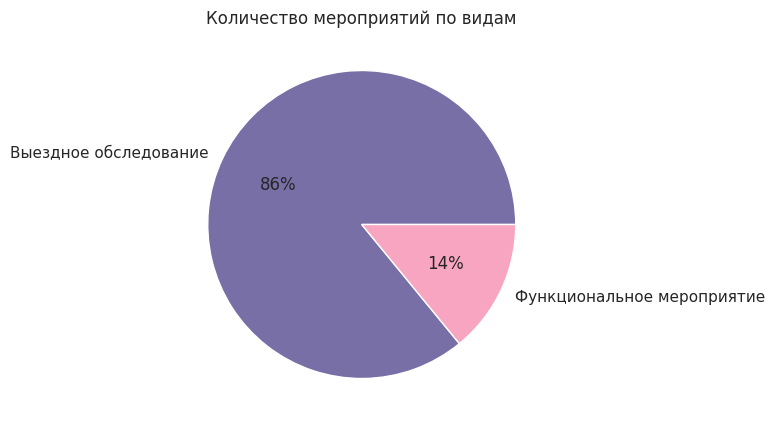

In [80]:
# Воспользуемся круговой диаграммой для отображения доли каждого из мероприятий

events_v = events_var['Вид мероприятия']
sizes = events_var['Количество']

fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(sizes,
       labels=events_v,
       autopct='%1.0f%%',
       colors=['#786fa6', '#f8a5c2'])
ax.set_title('Количество мероприятий по видам')
plt.show()

Bмеется всего два вида мероприятий. Выездное обследование и функциональное мероприятие. При этом 85% мероприятий это выездное обследование. На функциональное мероприятие приходятся оставшиеся 15%.

In [35]:
# Посмотрим на мероприятия в разрезе округов.
events_var_dist = events.groupby(['Округ', 'Вид мероприятия']).size().unstack(fill_value=0)
events_var_dist.sort_values(by='Выездное обследование', ascending=False, inplace=True)
events_var_dist.columns = ['Выездное обследование', 'Функциональное мероприятие']
print(events_var_dist)

       Выездное обследование  Функциональное мероприятие
Округ                                                   
ЦАО                      572                          68
ЮВАО                     505                          56
ВАО                      326                          93
СВАО                     259                          67
ЮАО                      228                          47
САО                      178                          37
ЗАО                      176                          33
СЗАО                     156                          29
ЗЕЛАО                    132                           8
НАО                       97                           5
ТАО                       87                           5
ЮЗАО                      50                           4
МО                         0                           1


А по окргуам лиируют: ЦАО, ЮВАО и ВАО. Количество выездных мероприятий в них больше остальных округов. Что в целом не удивительно, так как это самые большие окрга по количеству объектов.

### Результаты мероприятий

In [36]:
# Посмотрим какие есть результаты мероприятий.
results = events.groupby('Результат')['Тип объекта'].agg('count').sort_values(ascending=False)
results.columns = ['Результат', 'Количество']
results

Результат
Нецелевое использование ЗУ (прил. №3)              2020
Незаконное размещение объекта (прил. №2)            943
Отсутствие самостроя                                252
Определение площади самовольного строительства        2
Выявлены нарушения (главы 6 и 9 КоАП г. Москвы)       1
Частная собственность                                 1
Name: Тип объекта, dtype: int64

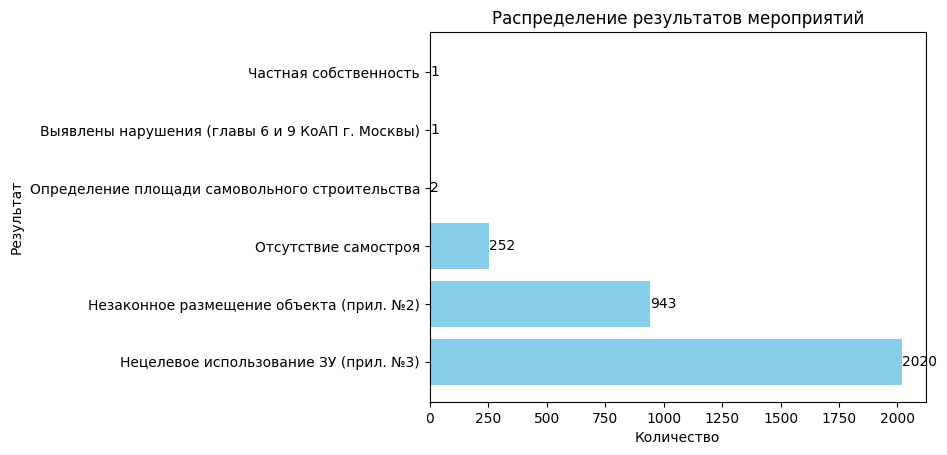

In [37]:
# Отобразим данные на гистограмме
fig, ax = plt.subplots()

ax.barh(results.index, results, color='skyblue')

# Добавим подписи к каждому столбцу
for i, v in enumerate(results):
    ax.text(v, i, str(v), va='center')

# Заголовки осей
ax.set_xlabel('Количество')
ax.set_ylabel('Результат')

# Устанавам заголовок графика
ax.set_title('Распределение результатов мероприятий')

# Рисуем график
plt.show()

Видим что наиболее частыми результатами мероприятий являются "Нецелевое использование ЗУ", "Незаконное размещение объекта" и "Отсутствие самостроя". При этом по количеству лидируем "Нецелевое использование ЗУ" со значением 2020 мероприятий. А если посмотреть процент то "Нецелевое использование ЗУ", "Незаконное размещение объекта" занимают 92% от общего количества проверок.

In [38]:
# Давайте посмотрим на результаты в резрезе округов
results_distr = events.pivot_table(index='Округ', columns='Результат', aggfunc='size', fill_value=0)
results_distr

Результат,Выявлены нарушения (главы 6 и 9 КоАП г. Москвы),Незаконное размещение объекта (прил. №2),Нецелевое использование ЗУ (прил. №3),Определение площади самовольного строительства,Отсутствие самостроя,Частная собственность
Округ,,,,,,
ВАО,0,128,239,2,50,0
ЗАО,0,20,168,0,21,0
ЗЕЛАО,0,27,107,0,6,0
МО,0,0,0,0,1,0
НАО,0,19,78,0,5,0
САО,0,24,188,0,3,0
СВАО,1,96,210,0,18,1
СЗАО,0,42,130,0,13,0
ТАО,0,13,74,0,5,0


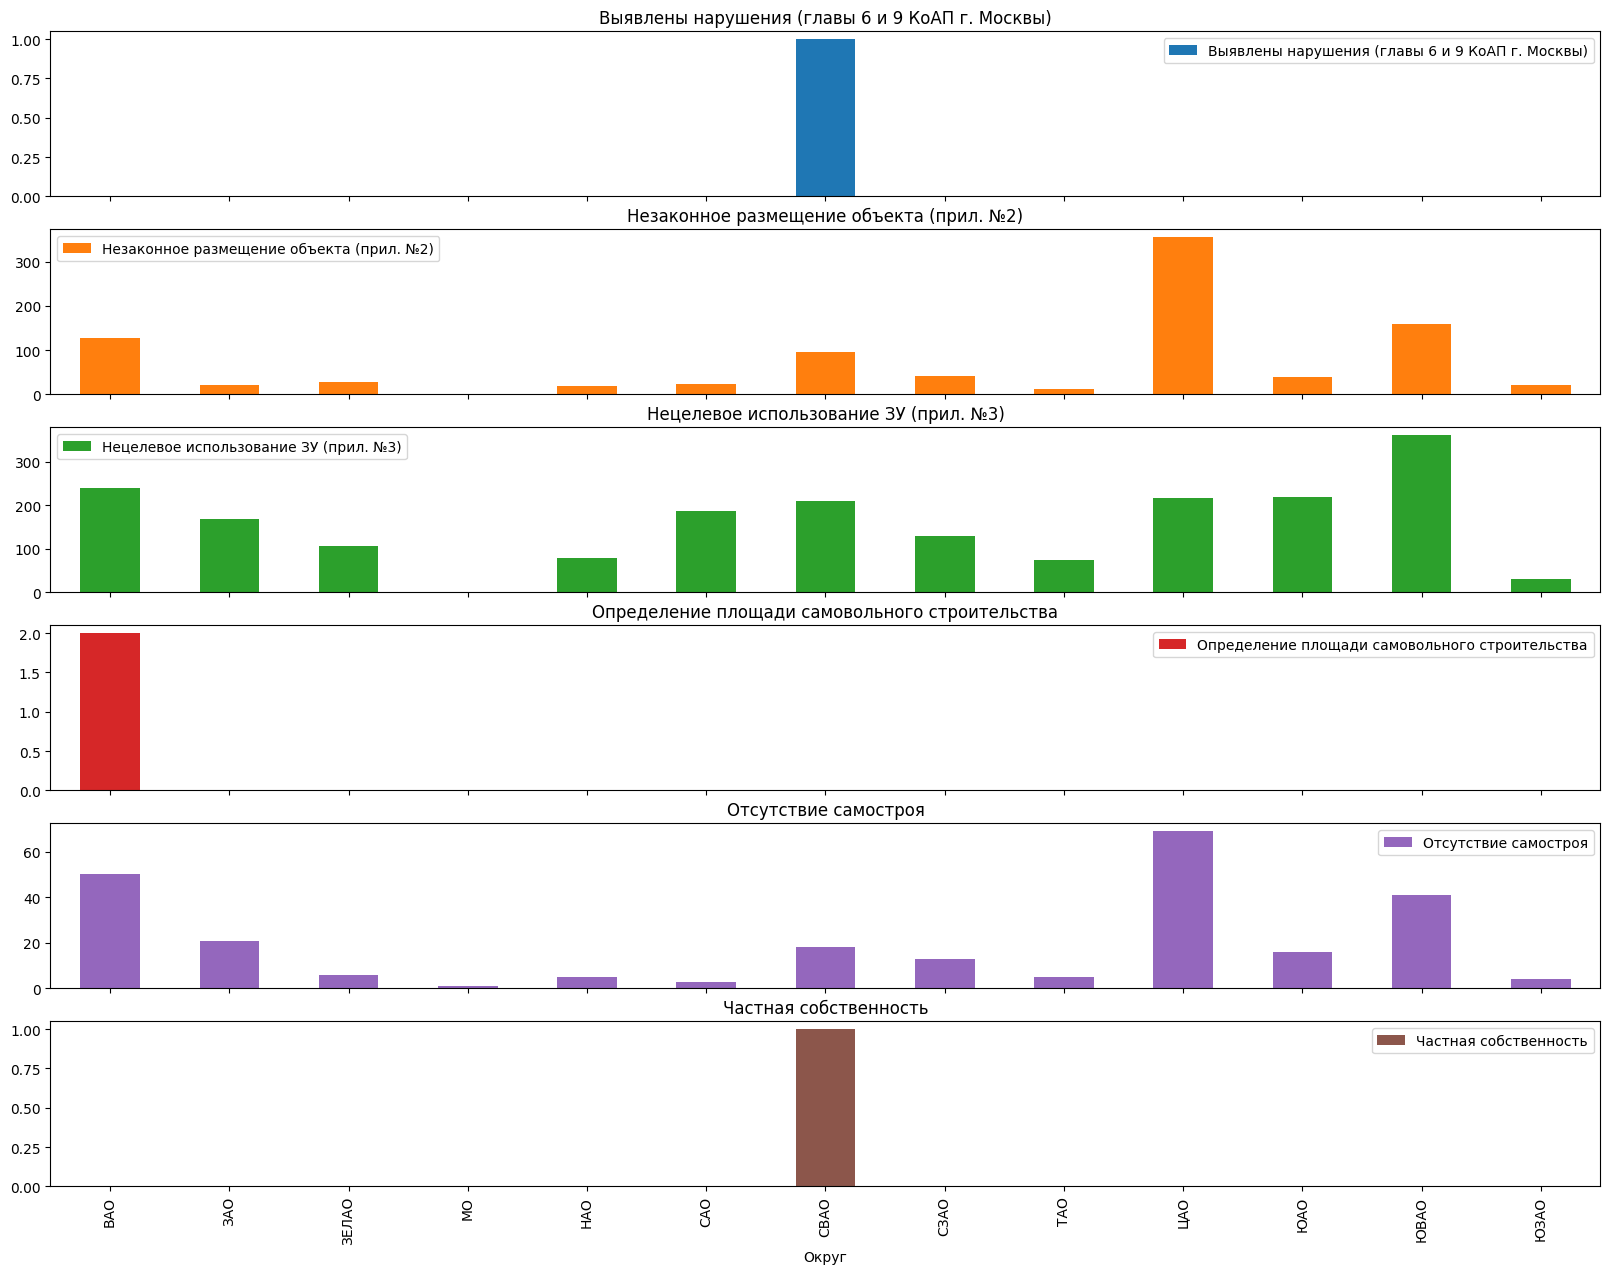

In [39]:
# Отобразим на графике
events.groupby(['Округ','Результат'])['Идентификатор мероприятия'].count().unstack(1).plot(kind='bar',
                                                                                           subplots = True,
                                                                                           figsize = (20,15))
plt.show()

По графику видим что больше всего результатов "Нецелевое использование ЗУ" наблюдается в таких округах: ЮВАО, ВАО, ЮАО, ЗАО, ЦАО, СВАО, и САО. Стоит обрать внимание что на третье место выходит ЮАО, а ЦАО занимает только четвертое.

А вот "Незаконное размещение объекта" в округах: ЦАО, ЮВАО, ВАО. А тут ЦАО в два раза по количеству привышает ЮВАО.

### Проверка обслуживание в отношении

In [83]:
# Посмотрим в отношении кого была проведена проверка.
events_ob = events.groupby('Проверка/обсл. в отношении',
                           as_index=False)['Тип объекта'].agg('count').sort_values(by = 'Проверка/обсл. в отношении',
                                                                                   ascending = False)
events_ob.columns = ['Проверка/обсл. в отношении', 'Количество']

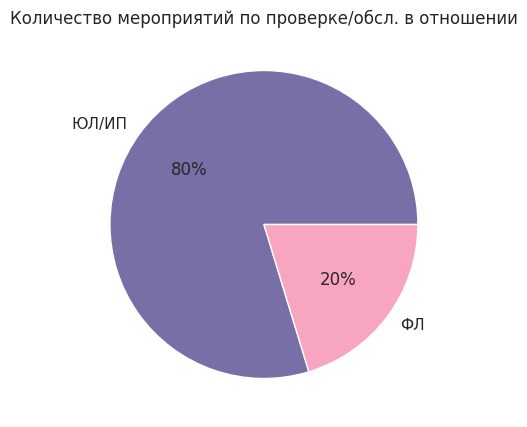

In [82]:
# Воспользуемся круговой диаграммой

# Извлекаем данные для списка
events_object = events_ob['Проверка/обсл. в отношении']
sizes = events_ob['Количество']

fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(sizes,
       labels=events_object,
       autopct='%1.0f%%',
       colors=['#786fa6', '#f8a5c2'])
ax.set_title('Количество мероприятий по проверке/обсл. в отношении')
plt.show()

Видим что 80% мероприятий направлены в отношении юр лиц. Что в целом логично.

### Характеристики объектов


In [42]:
# Посмотрим на типы объектов
objects_types = objects.groupby('Тип объекта',
                           as_index=False)['Идентификатор объекта'].agg('count').sort_values(by = 'Идентификатор объекта',
                                                                                   ascending = False)
objects_types.columns = ['Тип объекта', 'Количество']
objects_types

,Тип объекта,Количество
10,прочее,1075
9,пристройка,552
11,строение,541
4,здание,322
6,надстройка,210
7,отдельное строение,135
5,мансарда,47
2,гараж,21
1,ангар,18
0,ГСК,6


Если рассматривать объекты по типу, на первом месте находится тип прочее, за ним идут пристройка и строение.

In [43]:
# Давайте посмотрим на результаты в резрезе округов
objects_types_dist = objects.pivot_table(index='Округ', columns='Тип объекта', aggfunc='size', fill_value=0)
objects_types_dist

Тип объекта,ГСК,ангар,гараж,забор,здание,мансарда,надстройка,отдельное строение,павильон,пристройка,прочее,строение
Округ,,,,,,,,,,,,
Восточный,1,1,2,2,44,7,32,9,1,88,117,81
Западный,1,1,6,1,20,0,6,18,0,33,50,61
Зеленоград,0,0,1,0,8,0,4,1,0,26,30,30
Московская область,0,0,0,0,1,0,0,0,0,0,0,0
Новомосковский,0,1,3,0,22,0,1,9,0,8,24,25
Северный,0,1,3,0,9,2,5,1,0,28,97,61
Северо-Восточный,0,0,0,1,38,0,9,7,0,52,182,20
Северо-Западный,0,2,3,0,19,1,10,6,1,25,45,50
Троицкий,0,2,0,1,23,2,3,3,2,9,17,24


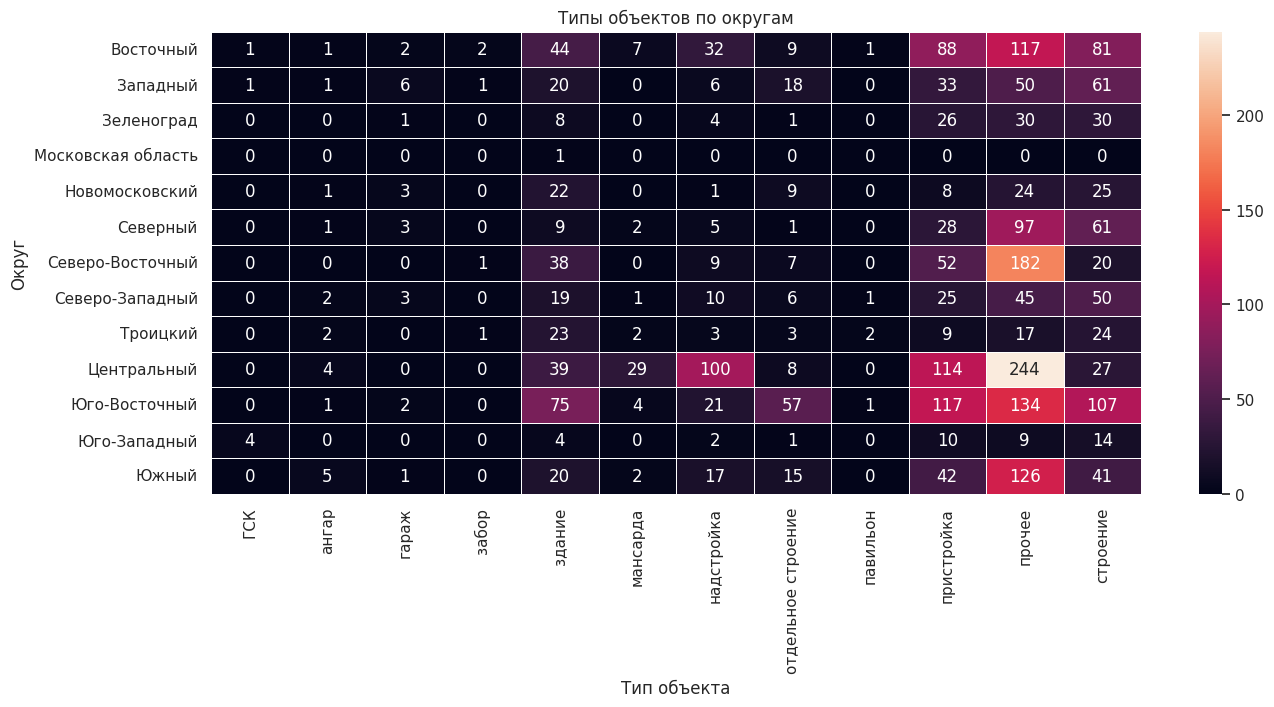

In [84]:
# Построим тепловую карту
sns.set_theme()

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(objects_types_dist, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Типы объектов по округам")
plt.show()

Что касается округов видим что прочее лидирует в округах: ЦАО, СВАО и ЮВАО. Пристройка в округах: ЮВАО, ЦАО и ВАО. Строение: ЮВАО и ВАО.

In [46]:
# Посмотрим на основания выявления/первого обследования
objects_eve = objects.groupby('Основание выявления/первого обследования',
                           as_index=False)['Идентификатор объекта'].agg('count').sort_values(by = 'Идентификатор объекта',
                                                                                   ascending = False)
objects_eve.columns = ['Основание выявления/первого обследования', 'Количество']
objects_eve

,Основание выявления/первого обследования,Количество
13,Поручения руководителя,1935
6,Обращения ОИВ (Правительство г.Москвы),468
10,Обследование не проводилось. Выявлен ГИН,159
0,Инициативно,142
2,Камеральные проверки,61
15,Тематические проверки,47
11,Обследование не проводилось. Выявлен ОИВ,41
8,Обращения граждан (ЭДО),32
1,Инструментальный мониторинг,25
7,"Обращения граждан (Портал ""Наш город"")",7


In [93]:
# В резрезе округов
objects_eve_dist = objects.pivot_table(index='Округ',
                                       columns='Основание выявления/первого обследования',
                                       aggfunc='size', fill_value=0)
# Перевернем таблицу
dist_eve_objects = transposed_table = objects_eve_dist.transpose()
dist_eve_objects

Округ,Восточный,Западный,Зеленоград,Московская область,Новомосковский,Северный,Северо-Восточный,Северо-Западный,Троицкий,Центральный,Юго-Восточный,Юго-Западный,Южный
Основание выявления/первого обследования,,,,,,,,,,,,,
Инициативно,14,79,4,0,1,14,3,8,8,2,5,4,0
Инструментальный мониторинг,0,3,0,0,5,0,0,0,3,2,12,0,0
Камеральные проверки,6,2,0,0,3,2,1,0,0,5,2,24,16
Мониторинг,0,0,0,0,0,0,1,0,0,0,0,0,2
Обращение,0,2,0,0,0,0,0,1,0,2,0,0,0
Обращения ОИВ (Правительство РФ),0,1,0,0,1,1,0,0,0,0,0,0,0
Обращения ОИВ (Правительство г.Москвы),66,95,8,1,13,30,43,21,18,129,26,9,9
"Обращения граждан (Портал ""Наш город"")",2,0,0,0,0,0,1,2,0,0,1,1,0
Обращения граждан (ЭДО),3,0,1,0,3,7,9,0,5,1,1,0,2


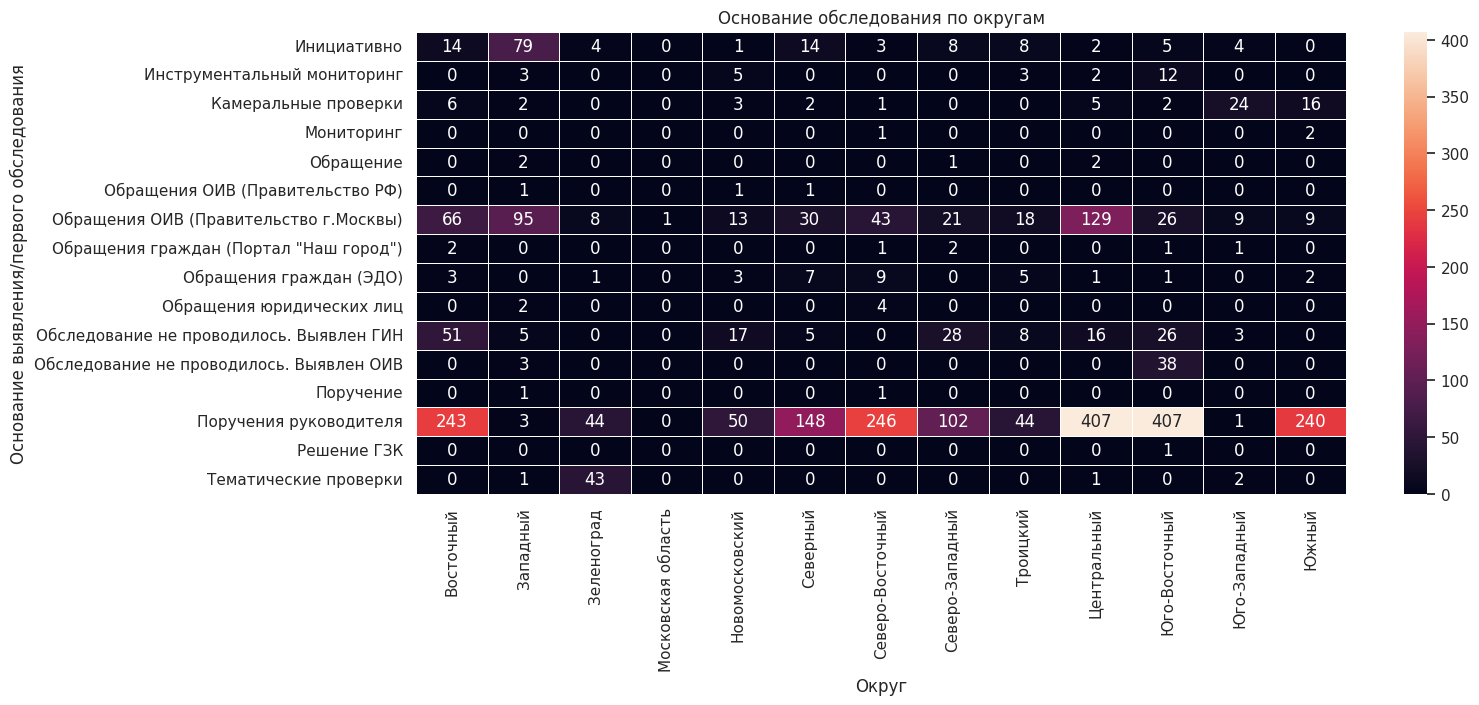

In [94]:
# Построим тепловую карту
sns.set_theme()

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(dist_eve_objects, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Основание обследования по округам")
plt.show()

Из оснований обселдования явно выделяется два типа: "Поручение руководителя" и "Обращения ОИВ (Правительство г.Москвы)"
При этом "Поручение руководителя" выделяется по округам: ЮВАО, ЦАО, СВАО, ВАО.
"Обращения ОИВ (Правительство г.Москвы)" по округам: ЦАО и ЗАО.

### Количество и распределение проверок по объектам

In [49]:
# Посмотрим на количество проверок
events_count_ch = events.groupby('ID объекта самостроя',
                           as_index=False)['Идентификатор мероприятия'].agg('count').sort_values(by = 'Идентификатор мероприятия',
                                                                                   ascending = False)
events_count_ch.columns = ['Идентификатор объекта', 'Количество']
top_objects = events_count_ch.head(5)
top_objects

,Идентификатор объекта,Количество
2530,57532,41
56,28429,9
2079,56280,7
2157,56554,7
2289,56869,6


В топ 5 объектов с наибольшим количеством проверок предствалены следующие: 57532, 28429, 56280, 56554, 56869. Явным лидером выглядит объект 57532 с количеством проверок 41 шт.

In [50]:
# Давайте посмотрим на результат первого и послежнего КИМ, округ и район
merged_tab = pd.merge(top_objects, objects[['Идентификатор объекта',
                                            'Округ',
                                            'Район',
                                            'Результат первого КИМ',
                                            'Результат последнего КИМ']],
                      on='Идентификатор объекта', how='left')
merged_tab

,Идентификатор объекта,Количество,Округ,Район,Результат первого КИМ,Результат последнего КИМ
0,57532,41,Центральный,Басманный,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
1,28429,9,Юго-Западный,Южное Бутово,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
2,56280,7,Центральный,Басманный,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
3,56554,7,Юго-Восточный,Лефортово,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
4,56869,6,Юго-Восточный,Рязанский,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)


Видим что в топ 5 объектов по количеству проверок находятся два объекта в районе Басманный, по одному в районах Южное Бутово, Лефортово и Рязанский.
При этом объект номер 57532 был проверен целых 41 раз, результаты первого и последнего КИМ Незаконное размещение объекта.

In [51]:
# Посмотрим на топ 5 объектов по каждому Округу
top_by_dist = (
events.groupby(['Округ','ID объекта самостроя'])['Идентификатор мероприятия']
  .count()
  .reset_index()
  .sort_values(by = ['Округ', 'Идентификатор мероприятия'], ascending = [True, False])
  .groupby(['Округ'])
  .head(5)
)
top_by_dist
top_by_dist.columns = ['Округ','Идентификатор объекта', 'Количество']
top_by_dist

,Округ,Идентификатор объекта,Количество
370,ВАО,58293,4
133,ВАО,52969,3
4,ВАО,22943,2
22,ВАО,48904,2
29,ВАО,50418,2
...,...,...,...
2899,ЮЗАО,28429,9
2898,ЮЗАО,28428,2
2893,ЮЗАО,16826,1
2894,ЮЗАО,16827,1


In [52]:
# Добавим результат первого и послежнего КИМ, округ и район
merged_tab_dist = pd.merge(top_by_dist, objects[['Идентификатор объекта',
                                            'Округ',
                                            'Район',
                                            'Результат первого КИМ',
                                            'Результат последнего КИМ']],
                      on='Идентификатор объекта', how='left')
merged_tab_dist

,Округ_x,Идентификатор объекта,Количество,Округ_y,Район,Результат первого КИМ,Результат последнего КИМ
0,ВАО,58293,4,Восточный,Косино-Ухтомский,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
1,ВАО,52969,3,Восточный,Гольяново,Демонтаж подтвержден,Демонтаж подтвержден
2,ВАО,22943,2,Восточный,Преображенское,Отсутствие самостроя,Отсутствие самостроя
3,ВАО,48904,2,Восточный,Соколиная Гора,Отсутствие самостроя,Отсутствие самостроя
4,ВАО,50418,2,Восточный,Вешняки,Определение площади самовольного строительства,Определение площади самовольного строительства
...,...,...,...,...,...,...,...
56,ЮЗАО,28429,9,Юго-Западный,Южное Бутово,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
57,ЮЗАО,28428,2,Юго-Западный,Южное Бутово,Незаконное размещение объекта (прил. №2),Незаконное размещение объекта (прил. №2)
58,ЮЗАО,16826,1,Юго-Западный,Зюзино,Отсутствие самостроя,Отсутствие самостроя
59,ЮЗАО,16827,1,Юго-Западный,Зюзино,Отсутствие самостроя,Отсутствие самостроя


Видим что лидером конечно остается Центральный округ. При этом есть округа как ЮВАО где выезды на объекты были от 3 до 7 раз, ЗЕЛАО от 4 до 6 раз с результатом "Незаконное размещение объекта" и "Демонтаж подтвержден."

### Частота проведения проверок

In [53]:
# Проведем группировку по месяу
grouped_by_month = events.groupby(pd.Grouper(key='Дата проверки/обсл', freq='M'))['Идентификатор мероприятия'].count()
grouped_by_month

Дата проверки/обсл
2023-01-31    188
2023-02-28    125
2023-03-31    313
2023-04-30    273
2023-05-31    221
2023-06-30    213
2023-07-31    230
2023-08-31    189
2023-09-30    198
2023-10-31    269
2023-11-30    248
2023-12-31    253
2024-01-31    188
2024-02-29    270
2024-03-31     41
Freq: M, Name: Идентификатор мероприятия, dtype: int64

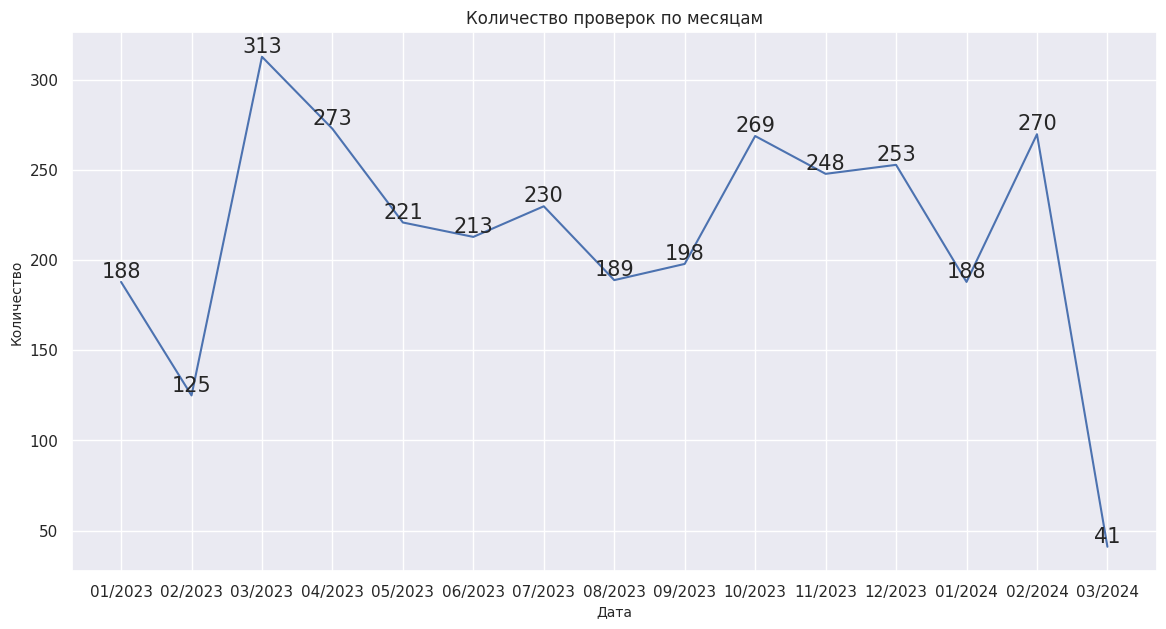

In [95]:
# Сбоерем список месяцев в отдельную переменную
months = events.groupby(pd.Grouper(key='Дата проверки/обсл', freq='M')).count().index.tolist()

# Изменим формат месяцев в 'MM/YYYY'
formatted_months = [i.strftime('%m/%Y') for i in months]

cat_am = pd.DataFrame({'date': formatted_months,
                   'count': events.groupby(pd.Grouper(key='Дата проверки/обсл', freq='M'))['Идентификатор мероприятия'].count().tolist()})

plt.figure(figsize=(14, 7))

plots = sns.lineplot(x=cat_am['date'], y=cat_am['count'], data=cat_am)

# Добавление аннотаций на линейный график
for i, row in cat_am.iterrows():
    plt.text(row['date'], row['count'], format(row['count'], '.0f'), ha='center', va='bottom', size=15)

plt.xlabel("Дата", size=10)
plt.ylabel("Количество", size=10)
plt.title("Количество проверок по месяцам")
plt.show()

Исходя из графика можно сказать, что явной закономерности или сезонности нет, присравненииданных за 2023 год с несколькими месяцами 2024 года. Видим что наибольшее количество проверов к 2023 году приходилось на Март месяц целых 313 шт. Так же выделяются Апрель и Октябрь с 273 и 269 проверками. А вот в 2024 году выделяется Февраль целых 270 проверок, при том что в 2023 году их было всего 125.

In [55]:
# В резрезе округов
date_dist_count = pd.pivot_table(events,
                                 index=pd.Grouper(key='Дата проверки/обсл', freq='M'),
                                 columns='Округ',
                                 values='Идентификатор мероприятия',
                                 aggfunc=np.size, fill_value=0)
date_dist_count

Округ,ВАО,ЗАО,ЗЕЛАО,МО,НАО,САО,СВАО,СЗАО,ТАО,ЦАО,ЮАО,ЮВАО,ЮЗАО
Дата проверки/обсл,,,,,,,,,,,,,
2023-01-31,35,8,1,0,7,10,32,18,2,12,18,41,4
2023-02-28,11,19,4,0,3,7,16,5,5,23,5,22,5
2023-03-31,38,32,18,0,5,19,35,17,7,39,26,60,17
2023-04-30,40,16,21,0,6,37,25,19,5,32,35,34,3
2023-05-31,29,14,18,0,2,12,27,14,10,24,18,50,3
2023-06-30,17,17,8,0,4,23,36,7,3,26,26,41,5
2023-07-31,23,19,14,0,6,13,41,7,3,19,20,63,2
2023-08-31,28,11,20,0,5,16,14,15,10,28,8,33,1
2023-09-30,42,12,4,0,8,3,12,13,9,38,19,36,2


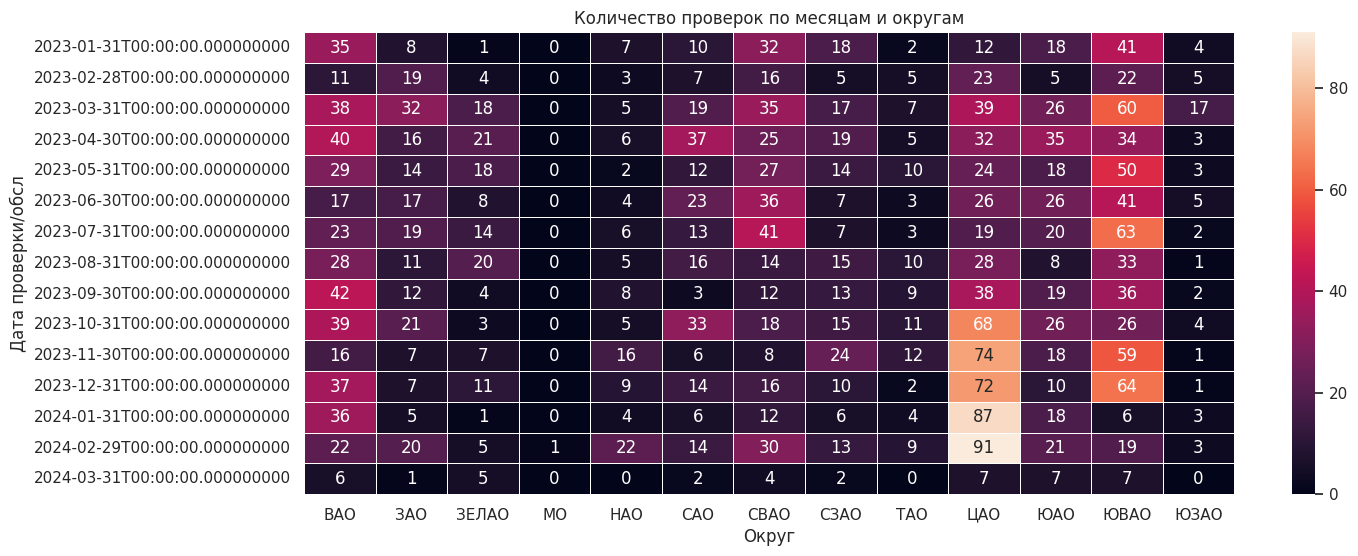

In [56]:
# Построим тепловую карту
sns.set_theme()

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(date_dist_count, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Количество проверок по месяцам и округам")
plt.show()

По карте видим что количество проверок с августа 2023 по январь 2024 возрастало в ЦАО, а так же осталось на высоком уровне в январе и феврале 2024 года. Так же стои отметить что в ЮВАО больше всего проверок было в марте, июле, ноябре и декабры. А вот в ВАО больше всего выделяются март, апрель, сентябрь и декабрь.

## 4)Вывод

Видим что около 50% процентов всех объектов находится в трех округах: ЦАО, ЮВАО и ВАО. При этом меньше всего в ТАО, ЮЗАО, МАО.

Топ 5 районов по количеству объектов занимают: Басманный, Печатники, Таганский, Соколиная Гора, Тверской.

При этом меется всего два вида мероприятий. Выездное обследование и функциональное мероприятие.
85% мероприятий это выездное обследование. На функциональное мероприятие приходятся оставшиеся 15%.

А по окргуам лиируют: ЦАО, ЮВАО и ВАО. Количество выездных мероприятий в них больше остальных округов. Что в целом не удивительно, так как это самые большие окрга по количеству объектов.

Наиболее частыми результатами мероприятий являются "Нецелевое использование ЗУ", "Незаконное размещение объекта" и "Отсутствие самостроя". При этом по количеству лидирует "Нецелевое использование ЗУ" со значением 2020 мероприятий. А если посмотреть процент то "Нецелевое использование ЗУ", "Незаконное размещение объекта" занимают 92% от общего количества проверок.

Больше всего результатов "Нецелевое использование ЗУ" наблюдается в таких округах: ЮВАО, ВАО, ЮАО, ЗАО, ЦАО, СВАО, и САО. Стоит обрать внимание что на третье место выходит ЮАО, а ЦАО занимает только пятое место.

А вот "Незаконное размещение объекта" в округах: ЦАО, ЮВАО, ВАО. А тут ЦАО в два раза по количеству привышает ЮВАО, на что так же стоит обратить внимание.

80% мероприятий направлены в отношении юр лиц. Что в целом логично.

Если рассматривать объекты по типу, на первом месте находится тип прочее, за ним идут пристройка и строение.

Что касается округов видим что прочее лидирует в округах: ЦАО, СВАО и ЮВАО. Пристройка в округах: ЮВАО, ЦАО и ВАО. Строение: ЮВАО и ВАО.

Из оснований обследования явно выделяется два типа: "Поручение руководителя" и "Обращения ОИВ (Правительство г.Москвы)" При этом "Поручение руководителя" выделяется по округам: ЮВАО, ЦАО, СВАО, ВАО. "Обращения ОИВ (Правительство г.Москвы)" по округам: ЦАО и ЗАО.

В топ 5 объектов с наибольшим количеством проверок предствалены следующие: 57532, 28429, 56280, 56554, 56869. Явным лидером выглядит объект 57532 с количеством проверок 41 шт.

Видим что лидером конечно остается Центральный округ. При этом есть округа как ЮВАО где выезды на объекты были от 3 до 7 раз, ЗЕЛАО от 4 до 6 раз с результатом "Незаконное размещение объекта" и "Демонтаж подтвержден."

Исходя из графика можно сказать, что явной закономерности или сезонности нет, при сравнении данных за 2023 год с несколькими месяцами 2024 года. Видим что наибольшее количество проверов к 2023 году приходилось на Март месяц целых 313 шт. Так же выделяются Апрель и Октябрь с 273 и 269 проверками. А вот в 2024 году выделяется Февраль целых 270 проверок, при том что в 2023 году их было всего 125.

По карте видим что количество проверок с августа 2023 по январь 2024 возрастало в ЦАО, а так же осталось на высоком уровне в январе и феврале 2024 года. Так же стои отметить что в ЮВАО больше всего проверок было в марте, июле, ноябре и декабры. А вот в ВАО больше всего выделяются март, апрель, сентябрь и декабрь.

### Рекомендации

Отдельно хочу отметить что ЮАО и ЗАО не самые крупные округа, при это занимаю 3 и 4 место по "Нецелевое использование ЗУ", в то время как самый крупный округ ЦАО только лишь 5 место.

Кроме этого ЦАО занимает лидирующее место по "Незаконное размещение объекта" что кажется логичным так как округ самый большой. Но тут стоит обратить внимание что количество нарушений в два раза больше чем у второй позиции.

Так же стоит обратить внимание на ЗЕЛАО, так как данный округ не будучи в числе топовых по количеству объектов имеет топ 5 объектов на которые выезжали от 4 до 6 раз.